# Baseline

## Общая инициализация
Нужно выполнить в самом начале независимо от дальнейших действий

### Путь к каталогу, в котором лежит датасет
датасет представлен файлом `train.csv` и папкой `train`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_folder = "/content/drive/MyDrive/train"

#### Инициализация путей

In [3]:
import os.path as path

In [4]:
# path
train_folder = path.join(base_folder, "train")
train_csv = path.join(base_folder, "train.csv")
train_pickle = path.join(base_folder, "train.pickle")
labels_pickle = path.join(base_folder, "labels.pickle")

### Изучение аудиофайлов датасета

In [5]:
import os
import random

import librosa
import librosa.feature as F

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio

In [6]:
# random filename from dir
files = os.listdir(train_folder)
filename = random.choice(files)
filename

'1b57f8c7391123673042.wav'

#### Спектрограмма

In [7]:

# spectrogram parameters
sample_rate = 11025

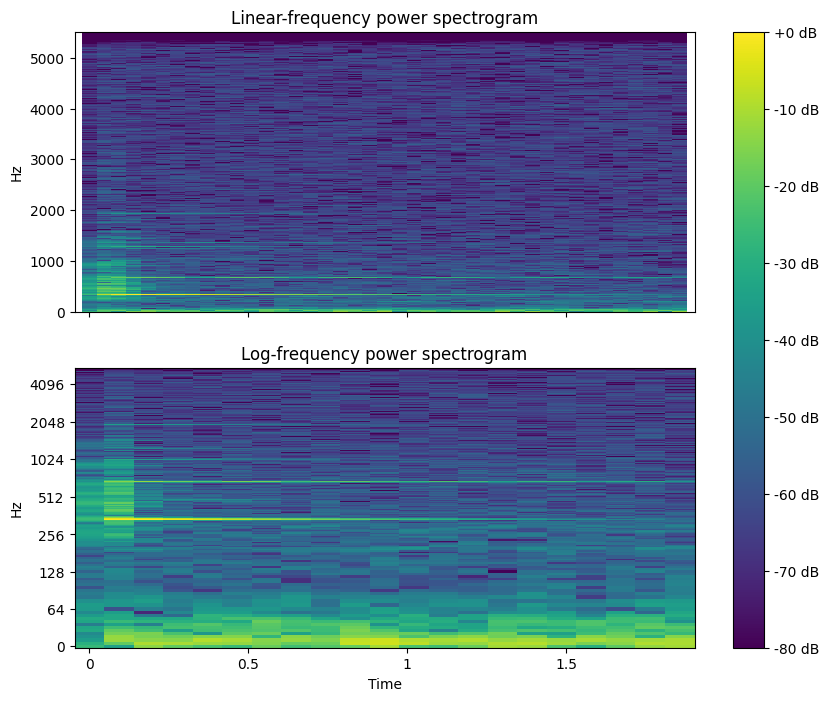

In [8]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

# draw linear-frequency spectrogram
hop_length = 512
wav_data_db = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length)),
    ref=np.max
)
img1 = librosa.display.specshow(
    wav_data_db,
    sr=sr,
    hop_length=hop_length,
    ax=ax_top,
    x_axis='time',
    y_axis='linear',
    cmap=cmap,
)
ax_top.set(title='Linear-frequency power spectrogram')
ax_top.label_outer()

# draw log-frequency spectrogram
hop_length = 1024
wav_data_db = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length)),
    ref=np.max
)
img2 = librosa.display.specshow(
    wav_data_db,
    sr=sr,
    hop_length=hop_length,
    ax=ax_bottom,
    x_axis='time',
    y_axis='log',
    cmap=cmap,
)
ax_bottom.set(title='Log-frequency power spectrogram')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))

#### Mel-спектрограмма

In [9]:
# melspectrogram parameters
sample_rate = 11025
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

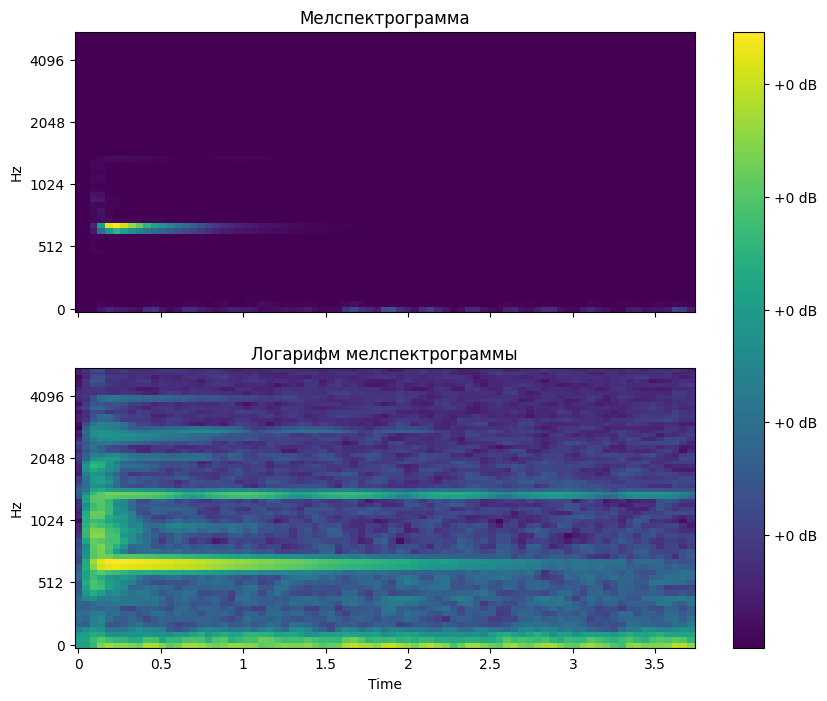

In [10]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

mel_spec = F.melspectrogram(
    y=wav_data,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
    fmax=sample_rate // 2
)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

img1 = librosa.display.specshow(
    mel_spec,
    sr=sr,
    fmax=sr // 2,
    ax=ax_top,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_top.set(title='Мелспектрограмма')
ax_top.label_outer()

D = librosa.power_to_db(mel_spec, ref=np.max)
img2 = librosa.display.specshow(
    D,
    sr=sr,
    fmax=sr // 2,
    ax=ax_bottom,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_bottom.set(title='Логарифм мелспектрограммы')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))

## Извлечение признаков

In [11]:
import os
import pickle
from enum import Enum
from typing import NoReturn, Optional

from tqdm import tqdm

import pandas as pd
import numpy as np

import librosa
import librosa.feature as F


class SetType(Enum):
    """Set type"""
    TRAIN = 1
    TEST  = 2
    DEV   = 3


def extract_log_mel_feats(set_type:SetType, path_to_csv:str, path_to_files:str,
                          out_path:str, labels_pickle:str, sr:Optional[int], n_fft:int,
                          hop_length:int, n_mels:int):
    """
    Extract features from given files and store them in binary format.

    :param set_type: set tyle
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param labels_pickle: path to store labels dictionary
    :param sr: input files sample rate
    :param n_fft: size of fft window
    :param hop_length: hop size
    :param n_mels: number of mel band

    :return:
    """
    if set_type not in [SetType.TRAIN, SetType.TEST]:
        raise Exception(f'Such set type not supported: {set_type}')

    feats = []

    if set_type == SetType.TRAIN:
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = librosa.load(os.path.join(path_to_files, file_name), sr=sr)
            mel_spec = F.melspectrogram(
                y=wav_data,
                n_fft=n_fft,
                hop_length=hop_length,
                n_mels=n_mels,
                fmax=sr // 2
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })

        pickle.dump(feats, open(out_path, 'wb'))
        pickle.dump(label_to_id, open(labels_pickle, 'wb'))
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = librosa.load(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                wav_data = np.zeros(sr)
            mel_spec = F.melspectrogram(
                y=wav_data,
                n_fft=n_fft,
                hop_length=hop_length,
                n_mels=n_mels,
                fmax=sr // 2
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

        pickle.dump(feats, open(out_path, 'wb'))
        return

In [12]:
# feature extraction parameters
sample_rate = 11025
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

In [13]:
# extract features and store to `train_pickle` extracted features
label_to_id = extract_log_mel_feats(
    SetType.TRAIN,
    train_csv,
    train_folder,
    train_pickle,
    labels_pickle,
    sample_rate,
    n_fft,
    hop_length,
    n_mels
)

id_to_label = [label for label, i in label_to_id.items()]

Total files: 5683


5683it [09:31,  9.95it/s]


In [14]:
!nvidia-smi

Sun Nov 30 15:25:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Алгоритм детектирования

### Подготовительный этап

In [15]:
from typing import NoReturn
from pprint import pprint
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
device = device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
cpu_count = os.cpu_count()

num_workers = cpu_count if device == "cpu" else 0
num_workers, cpu_count

(0, 2)

#### Добиваемся максимальной воспроизводимости
Согласно данному мануалу: https://pytorch.org/docs/stable/notes/randomness.html

In [18]:
def set_random_state(random_state:int=0) -> NoReturn:
    """Initialize random generators.

    Parameters
    ==========
    random_state : int = 0
        Determines random number generation for centroid initialization.
        Use an int to make the randomness deterministic.
    """
    torch.manual_seed(random_state)
    random.seed(random_state)
    np.random.seed(random_state)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        torch.cuda.manual_seed(random_state)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [19]:
random_state = 42

In [20]:
set_random_state(random_state)

In [21]:
torch.use_deterministic_algorithms(True)

In [22]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%env PYTHONHASHSEED=42

env: CUBLAS_WORKSPACE_CONFIG=:4096:8
env: PYTHONHASHSEED=42


### Архитектура нейронной сети

In [23]:
class DummyNetwork(nn.Module):
    """Neural network base architecture"""
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=64, kernel_size=5, stride=(2, 2), device=device)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1), device=device)
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1), device=device)

        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))

        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)

        self.bn1 = nn.BatchNorm2d(num_features=64, device=device)
        self.bn2 = nn.BatchNorm2d(num_features=96, device=device)
        self.bn3 = nn.BatchNorm2d(num_features=64, device=device)

        self.flat = nn.Flatten()

        # 33856 - должно соответствовать форме self.flat
        self.fc1 = nn.Linear(33856, 41, device=device)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)

        x = self.flat(x)

        # здесь можно еще добавить полносвязный слой или слои
        x = self.fc1(x)

        return x

In [24]:
set_random_state(random_state) # try to run this cell several times
                               # then comment this line and run it several times again
                               # * pay attention at tensors values

# random 4D tensor
random_input = torch.randn(1, 1, 64, 64, requires_grad=True, device=device)

print(f"Исходный тензор {list(random_input.shape)}:")
pprint(random_input)

# create neural network instance
network = DummyNetwork()

# pass data throught the neural network
output = network(random_input)

print(f"\nТензор на выходе нейронной сети {list(output.shape)}:")
pprint(output)

Исходный тензор [1, 1, 64, 64]:
tensor([[[[ 0.1940,  2.1614, -0.1721,  ..., -0.8146,  0.2502, -0.4273],
          [ 1.1044, -1.1028,  0.5543,  ..., -1.2072, -0.2438, -0.6784],
          [ 0.1973,  0.9782, -0.0287,  ..., -0.1266, -0.4321, -1.3943],
          ...,
          [-1.1998,  0.5818, -0.7198,  ..., -0.6079, -1.8145,  0.2807],
          [-0.0970,  0.9319, -0.4393,  ..., -0.1155, -0.0528,  1.1175],
          [ 3.0098,  1.3304, -1.1632,  ...,  0.1124,  0.2769, -1.2535]]]],
       device='cuda:0', requires_grad=True)

Тензор на выходе нейронной сети [1, 41]:
tensor([[-0.0437, -0.6455,  0.1273,  0.9486, -0.8313,  0.8500,  0.1742, -0.0384,
          0.0782, -0.9897,  0.4222, -0.0865, -0.6966,  1.0091,  1.0284,  0.4896,
          2.2631,  1.4351, -1.2141, -0.2496, -0.6252,  0.4495,  0.6215, -0.5325,
          0.4246,  0.3917,  1.0390, -0.3208,  0.2416,  1.5850, -1.0630,  1.2164,
         -2.0217, -0.4829,  0.4148,  0.4027,  0.2401,  1.1255, -0.9951, -1.2362,
         -0.8311]], device=

### Шаг оптимизации

In [25]:
import torch.optim as optim

In [26]:
set_random_state(random_state)


# choose loss function
criterion = nn.CrossEntropyLoss()

# choose and tune optimizer
optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer.zero_grad()

random_input = torch.randn(3, 1, 64, 64, requires_grad=True, device=device)
print(f"Тензор на входе сети {list(random_input.shape)}:")
pprint(random_input)

output = network(random_input)
print(f"\nТензор на выходе сети {list(output.shape)}:")
pprint(output)

target = torch.randint(5, (3,), dtype=torch.long, device=device)
print(f"\nТензор с целевыми значениями {list(target.shape)}:")
pprint(target)

loss = criterion(output, target)
print("\nЗначение функции потерь:", loss.item())

# backpropagation
loss.backward()

# next step
optimizer.step()

Тензор на входе сети [3, 1, 64, 64]:
tensor([[[[ 0.1940,  2.1614, -0.1721,  ..., -0.8146,  0.2502, -0.4273],
          [ 1.1044, -1.1028,  0.5543,  ..., -1.2072, -0.2438, -0.6784],
          [ 0.1973,  0.9782, -0.0287,  ..., -0.1266, -0.4321, -1.3943],
          ...,
          [-1.1998,  0.5818, -0.7198,  ..., -0.6079, -1.8145,  0.2807],
          [-0.0970,  0.9319, -0.4393,  ..., -0.1155, -0.0528,  1.1175],
          [ 3.0098,  1.3304, -1.1632,  ...,  0.1124,  0.2769, -1.2535]]],


        [[[ 1.1346, -0.6329, -0.9147,  ..., -1.5122, -1.1374,  0.7628],
          [ 0.9661, -0.0587, -0.2129,  ...,  1.2377,  0.5842,  1.6728],
          [ 0.7942,  0.3131, -0.3607,  ...,  0.1261, -0.1309,  2.0342],
          ...,
          [-0.3319,  0.8590,  0.7535,  ..., -1.2910, -0.3644,  0.9805],
          [-0.5130,  0.6719, -0.1551,  ..., -0.4551, -0.1417, -1.2772],
          [-0.4063,  0.0820,  0.8311,  ..., -1.0449,  1.5397, -2.0042]]],


        [[[-0.5852, -0.9346,  0.9684,  ...,  0.5966, -1.6748,

### Обучение нейронной сети

#### Загрузка ранее извлеченных признаков и подготовка данных для обучения

In [27]:
import pickle

In [28]:
train_data = pickle.load(open(train_pickle, "rb"))

label_to_id = pickle.load(open(labels_pickle, "rb"))
id_to_label = [label for label, i in label_to_id.items()]

In [29]:
def prepare_shape(feature):
    tmp = feature
    N = 64 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, :N]
    return tmp

In [30]:
# можно улучшить, используя сбалансированное валидационное множество
# гуглить stratified train test split sklearn
validation_set_size = 800

x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(train_data):
    feature = prepare_shape(row['feature'])
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])

x_val = np.asarray(x_val)
x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

print(f"""
Train set:
    x.shape: {x_tr.shape}
    y.shape: {y_tr.shape}

Validation set:
    x.shape: {x_val.shape}
    y.shape: {y_val.shape}
""")


Train set:
    x.shape: (4883, 1, 64, 64)
    y.shape: (4883,)

Validation set:
    x.shape: (800, 1, 64, 64)
    y.shape: (800,)



In [31]:
from torch.utils.data import Dataset

In [32]:
class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None, device="cpu"):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape()
        if self.y is not None:
            return \
                torch.tensor(self.x[idx], device=device),\
                torch.tensor(self.y[idx], device=device)

        return torch.tensor(self.x[idx], device=device)

In [33]:
train_dset = EventDetectionDataset(x_tr, y_tr, device=device)
val_dset = EventDetectionDataset(x_val, y_val, device=device)

In [34]:
set_random_state(random_state)

sample_x, sample_y = random.choice(val_dset)

sample_y.item(), id_to_label[sample_y]

(10, np.str_('Cough'))

In [35]:
import librosa
import matplotlib.pyplot as plt

In [36]:
sample_rate = 11025

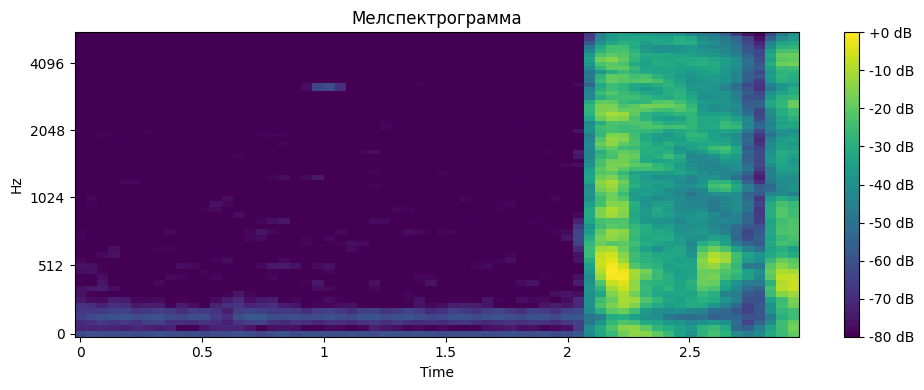

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cmap = "viridis"

img = librosa.display.specshow(
    sample_x[0].numpy(force=True),
    sr=sample_rate,
    fmax=sample_rate // 2,
    ax=ax,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax.set(title='Мелспектрограмма')
ax.label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.tight_layout()
plt.show()

In [38]:
from torch.utils.data import DataLoader

In [39]:
train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=num_workers)

In [40]:
import time
from sklearn.metrics import accuracy_score, f1_score

In [41]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR, StepLR

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import f1_score, classification_report
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import time

In [43]:
torch.use_deterministic_algorithms(False)

start_time = time.time()

n_epoch = 250
set_random_state(random_state)

class EnhancedAudioNet(nn.Module):
    def __init__(self, num_classes=41):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 96, 5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(96)

        self.conv2 = nn.Conv2d(96, 192, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(192)

        self.conv3 = nn.Conv2d(192, 384, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(384)

        self.conv4 = nn.Conv2d(384, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 32, 1),
            nn.ReLU(),
            nn.Conv2d(32, 512, 1),
            nn.Sigmoid()
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(512, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(384, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout2d(0.4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)

        attention_weights = self.attention(x)
        x = x * attention_weights
        x = self.dropout(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = EnhancedAudioNet(num_classes=41).to(device)

print("Тестирование модели")
test_input = torch.randn(2, 1, 64, 64).to(device)
try:
    output = model(test_input)
    print(f"Размеры: вход {test_input.shape}, выход {output.shape}")
except Exception as e:
    print(f"Ошибка при тестировании: {e}")
    class FallbackNet(nn.Module):
        def __init__(self, num_classes=41):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(1, 96, 5, stride=2, padding=2),
                nn.BatchNorm2d(96),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout2d(0.4),
                nn.Conv2d(96, 192, 3, padding=1),
                nn.BatchNorm2d(192),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout2d(0.4),
                nn.Conv2d(192, 384, 3, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d((1, 1)),
            )
            self.classifier = nn.Sequential(
                nn.Linear(384, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(256, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128, num_classes)
            )

        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            return x

    model = FallbackNet(num_classes=41).to(device)

class WarmupAdamW(optim.AdamW):
    def __init__(self, params, lr=1e-3, warmup_epochs=10, **kwargs):
        super().__init__(params, lr=0.0, **kwargs)
        self.warmup_epochs = warmup_epochs
        self.final_lr = lr
        self.current_epoch = 0

    def step(self, epoch=None):
        if epoch is not None:
            self.current_epoch = epoch

        if self.current_epoch < self.warmup_epochs:
            lr_scale = (self.current_epoch + 1) / self.warmup_epochs
            for param_group in self.param_groups:
                param_group['lr'] = self.final_lr * lr_scale
        else:
            for param_group in self.param_groups:
                param_group['lr'] = self.final_lr

        super().step()

optimizer = WarmupAdamW(
    model.parameters(),
    lr=0.0015,
    warmup_epochs=10,
    weight_decay=0.002,
    betas=(0.9, 0.999)
)

cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)
plateau_scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=8, factor=0.7, min_lr=1e-7)

criterion = nn.CrossEntropyLoss(label_smoothing=0.15)

train_losses = []
val_scores = []
best_f1 = 0.0
best_weights = None
patience_counter = 0

for epoch in range(n_epoch):
    print(f'Эпоха: {epoch+1}/{n_epoch}')

    optimizer.step(epoch)

    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        preds = output.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    train_f1 = f1_score(all_targets, all_preds, average='weighted')

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    val_preds = []
    val_targets = []
    val_loss = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
            preds = output.argmax(dim=1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()
    val_f1 = f1_score(val_targets, val_preds, average='weighted')

    val_scores.append(val_f1)

    print(f'Потери: {train_losses[-1]:.4f}, F1 обуч: {train_f1:.4f}, F1 валид: {val_f1:.4f}')

    cosine_scheduler.step()
    plateau_scheduler.step(val_f1)

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_weights = model.state_dict().copy()
        patience_counter = 0
        print(f'Лучший результат: {best_f1:.4f}')

        if best_f1 > 0.45:
            torch.save(best_weights, f'best_model_{best_f1:.4f}.pth')
    else:
        patience_counter += 1
        if patience_counter >= 30:
            print(f'Остановка на эпохе {epoch+1}')
            break

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Скорость обучения: {current_lr:.6f}')

if best_weights is not None:
    model.load_state_dict(best_weights)
print(f'Итоговый F1: {best_f1:.4f}')
print(f'Затрачено времени: {(time.time() - start_time):.2f} сек')

if best_f1 < 0.55:
    print("Создание ансамбля моделей")

    models_predictions = []
    models_probs = []

    for i in range(4):
        print(f"Модель {i+1}/4")

        ensemble_model = EnhancedAudioNet(num_classes=41).to(device)
        ensemble_model.load_state_dict(best_weights)

        lr_options = [0.0001, 0.00015, 0.00008, 0.00012]
        wd_options = [0.001, 0.002, 0.0005, 0.0015]

        ensemble_optimizer = optim.AdamW(
            ensemble_model.parameters(),
            lr=lr_options[i],
            weight_decay=wd_options[i]
        )

        ft_epochs = [12, 15, 8, 10][i]

        ensemble_model.train()
        for ft_epoch in range(ft_epochs):
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                ensemble_optimizer.zero_grad()
                output = ensemble_model(x)
                loss = criterion(output, y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(ensemble_model.parameters(), 0.5)
                ensemble_optimizer.step()

        ensemble_model.eval()
        with torch.no_grad():
            run_preds = []
            run_probs = []
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output = ensemble_model(x)
                probs = F.softmax(output, dim=1)
                preds = output.argmax(dim=1)
                run_preds.append(preds.cpu())
                run_probs.append(probs.cpu())

            models_predictions.append(torch.cat(run_preds).numpy())
            models_probs.append(torch.cat(run_probs, dim=0).numpy())

    avg_probs = np.mean(models_probs, axis=0)
    soft_preds = np.argmax(avg_probs, axis=1)
    soft_f1 = f1_score(val_targets, soft_preds, average='weighted')

    hard_preds = []
    for i in range(len(models_predictions[0])):
        votes = [pred[i] for pred in models_predictions]
        hard_pred = max(set(votes), key=votes.count)
        hard_preds.append(hard_pred)
    hard_f1 = f1_score(val_targets, hard_preds, average='weighted')

    ensemble_f1 = max(soft_f1, hard_f1)
    print(f'F1 soft voting: {soft_f1:.4f}')
    print(f'F1 hard voting: {hard_f1:.4f}')
    print(f'F1 ансамбля: {ensemble_f1:.4f}')

    if ensemble_f1 > best_f1:
        best_f1 = ensemble_f1
        print(f'Ансамбль улучшил результат: {best_f1:.4f}')

print(f'Лучший F1: {best_f1:.4f}')

Тестирование модели
Размеры: вход torch.Size([2, 1, 64, 64]), выход torch.Size([2, 41])
Эпоха: 1/250
Потери: 3.7818, F1 обуч: 0.0278, F1 валид: 0.0177
Лучший результат: 0.0177
Скорость обучения: 0.000150
Эпоха: 2/250
Потери: 3.6660, F1 обуч: 0.0394, F1 валид: 0.0278
Лучший результат: 0.0278
Скорость обучения: 0.000298
Эпоха: 3/250
Потери: 3.5564, F1 обуч: 0.0552, F1 валид: 0.0561
Лучший результат: 0.0561
Скорость обучения: 0.000444
Эпоха: 4/250
Потери: 3.4239, F1 обуч: 0.0712, F1 валид: 0.0695
Лучший результат: 0.0695
Скорость обучения: 0.000588
Эпоха: 5/250
Потери: 3.3465, F1 обуч: 0.0884, F1 валид: 0.1094
Лучший результат: 0.1094
Скорость обучения: 0.000731
Эпоха: 6/250
Потери: 3.2764, F1 обуч: 0.1030, F1 валид: 0.1304
Лучший результат: 0.1304
Скорость обучения: 0.000873
Эпоха: 7/250
Потери: 3.2348, F1 обуч: 0.1161, F1 валид: 0.1441
Лучший результат: 0.1441
Скорость обучения: 0.001012
Эпоха: 8/250
Потери: 3.1733, F1 обуч: 0.1297, F1 валид: 0.1896
Лучший результат: 0.1896
Скорость обу

In [44]:
def extract_test_features(path_to_files, out_path, sr, n_fft, hop_length, n_mels):
    """
    Extract features from test files and store them in binary format.
    """
    feats = []

    print("Извлечение признаков из тестовых данных")

    for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
        file_path = os.path.join(path_to_files, file_name)

        wav_data, sr = librosa.load(file_path, sr=sr)

        if len(wav_data) == 0:
            wav_data = np.zeros(sr)

        mel_spec = librosa.feature.melspectrogram(
            y=wav_data,
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            fmax=sr // 2
        )

        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        feats.append({
            'fname': file_name,
            'feature': log_mel_spec,
        })

    pickle.dump(feats, open(out_path, 'wb'))
    print(f"Признаки сохранены в {out_path}")
    return

test_folder = path.join(base_folder, "test")
test_pickle = path.join(base_folder, "test.pickle")

if os.path.exists(test_folder):
    print(f"Найдена папка с тестовыми данными: {test_folder}")
    print(f"Файлов в папке: {len(os.listdir(test_folder))}")
else:
    print(f"Папка не найдена: {test_folder}")
    test_folder = "/content/drive/MyDrive/train/test"

extract_test_features(
    test_folder,
    test_pickle,
    sample_rate,
    n_fft,
    hop_length,
    n_mels
)

Найдена папка с тестовыми данными: /content/drive/MyDrive/train/test
Файлов в папке: 3790
Извлечение признаков из тестовых данных


3790it [05:28, 11.53it/s]


Признаки сохранены в /content/drive/MyDrive/train/test.pickle


In [45]:
test_data = pickle.load(open(test_pickle, "rb"))

print(f"Загружено {len(test_data)} тестовых записей")

x_test = []
test_filenames = []

print("Подготовка тестовых данных")
for i, row in enumerate(test_data):
    feature = prepare_shape(row['feature'])
    x_test.append(feature)
    test_filenames.append(row['fname'])

x_test = np.asarray(x_test)

print(f"Тестовые данные подготовлены:")
print(f"Количество файлов: {len(test_filenames)}")
print(f"Пример имени файла: {test_filenames[0]}")

Загружено 3790 тестовых записей
Подготовка тестовых данных
Тестовые данные подготовлены:
Количество файлов: 3790
Пример имени файла: bd02ceddb68f91cbd20f.wav


In [46]:
class TestDataset(Dataset):
    def __init__(self, x, device="cpu"):
        self.x = x
        self.device = device

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], device=self.device)

test_dset = TestDataset(x_test, device=device)
test_loader = DataLoader(test_dset, batch_size=41, shuffle=False, num_workers=num_workers)

print("Test DataLoader создан")
print(f"Устройство: {device}")

Test DataLoader создан
Устройство: cuda


In [47]:
network.eval()

all_test_preds = []
all_test_probs = []

print("Предсказание на тестовых данных")

with torch.no_grad():
    for i, x in enumerate(tqdm(test_loader)):
        x = x.to(device)
        output = network(x)
        probs = F.softmax(output, dim=1)
        preds = output.argmax(dim=1)

        all_test_preds.append(preds.cpu())
        all_test_probs.append(probs.cpu())

all_test_preds = torch.cat(all_test_preds).numpy()

print(f"Конец тестирования")
print(f"Всего предсказаний: {len(all_test_preds)}")
print(f"Уникальные предсказанные классы: {np.unique(all_test_preds)}")

Предсказание на тестовых данных


100%|██████████| 93/93 [00:00<00:00, 148.59it/s]

Конец тестирования
Всего предсказаний: 3790
Уникальные предсказанные классы: [3]


In [49]:
label_to_id = pickle.load(open(labels_pickle, "rb"))
id_to_label = {v: k for k, v in label_to_id.items()}

print("Маппинг")
for i in range(min(10, len(id_to_label))):
    print(f"   {i} -> {id_to_label[i]}")

results = []

print("Создание CSV")

for filename, pred_id in zip(test_filenames, all_test_preds):
    if pred_id in id_to_label:
        label_name = id_to_label[pred_id]
    else:
        label_name = id_to_label[0]
        print(f"ID {pred_id} нет в маппинге, использован класс {label_name}")

    results.append({
        'fname': filename,
        'label': label_name
    })

results_df = pd.DataFrame(results)

output_csv_path = path.join(base_folder, "test_predictions.csv")
results_df.to_csv(output_csv_path, index=False)

print(f"CSV файл: {output_csv_path}")

Маппинг
   0 -> Acoustic_guitar
   1 -> Applause
   2 -> Bark
   3 -> Bass_drum
   4 -> Burping_or_eructation
   5 -> Bus
   6 -> Cello
   7 -> Chime
   8 -> Clarinet
   9 -> Computer_keyboard
Создание CSV
CSV файл: /content/drive/MyDrive/train/test_predictions.csv
